In [1]:
import classifiers.labeller as labeller
import nn_train_driver
import plotting.plot_shortcuts as ps

import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.metrics import classification_report

Computing Label Space...


100%|████████████████████████████████████████████████████████████████████████████████| 242/242 [00:05<00:00, 42.60it/s]

      EpochTime  Label  Label_Signal
0  1.641220e+09    1.0    400.144678
1  1.641220e+09    1.0    400.259335
2  1.641220e+09    1.0    400.337566
3  1.641220e+09    1.0    400.437786
4  1.641220e+09    1.0    400.558764


<module 'matplotlib.pyplot' from 'C:\\Users\\cwass\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

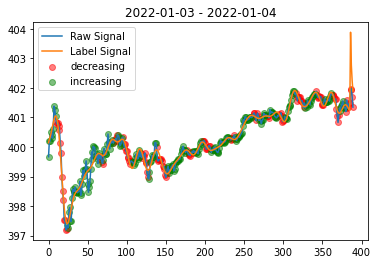

In [2]:
# read in data
data_df = pd.read_csv('./data/qqq_2022.csv')

# produce truth labels
print('Computing Label Space...')
label_df = labeller.driver(data_df, 21, 'Close')
print(label_df.head())

# plot data/labels/label signal
ps.plot_label_over_signal(data_df.iloc[:390], label_df.iloc[:390], 'Close')

# ARIMA Assessment

# Neural Net Assessment

MLP Hyperparameter Configuration:
{'activation': 'softmax',
 'epochs': 3,
 'in_shape': 18,
 'loss': 'categorical_crossentropy',
 'metrics': ['accuracy'],
 'n_fft_components': 8,
 'out_shape': 2,
 'periods': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
 'signal_data_column': 'Close'}

Training MLP:
Epoch 1/3
2350/2350 [==============================] - 6s 2ms/step - loss: 0.5862 - accuracy: 0.6929
Epoch 2/3
2350/2350 [==============================] - 5s 2ms/step - loss: 0.5818 - accuracy: 0.6959
Epoch 3/3
588/588 [==============================] - 1s 879us/step

Test Space Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.69      0.69      9248
         1.0       0.70      0.70      0.70      9545

    accuracy                           0.69     18793
   macro avg       0.69      0.69      0.69     18793
weighted avg       0.69      0.69      0.69     18793



<module 'matplotlib.pyplot' from 'C:\\Users\\cwass\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

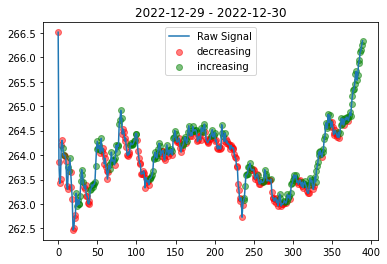

In [8]:
# use the default config file for building/training the Multilayer Perceptron
nn_config = nn_train_driver.default_training_config()
print(f'MLP Hyperparameter Configuration:')
pprint(nn_config)

# build/train the MLP
print('\nTraining MLP:')
model, test_df = nn_train_driver.train_mlp(data_df, label_df=label_df, config=nn_config)

# format the test df to just be the feature space
feature_cols = list(test_df.columns)
feature_cols.remove('EpochTime')
feature_cols.remove('Label')

# get the properly formatted test space
y_test_true = test_df['Label']
yhat_test = nn_train_driver.inverse_onehot(model.predict(test_df[feature_cols]))
print(f'\nTest Space Classification Report:\n{classification_report(y_test_true, yhat_test)}')

# plot the NN classifications on the last few days of data
yhat_test_df = pd.DataFrame({'EpochTime': test_df['EpochTime'].values,
                             'Label': yhat_test})
ps.plot_label_over_signal(data_df.iloc[-390:], yhat_test_df.iloc[-390:], 'Close')